#### Sampling method choice
###### in this choice we will evaluate the sampling methods for xgboost

In [56]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

In [57]:
df = pd.read_csv(r"Churn_clean.csv")
df.head()

,Flag_Richiesta_Estinzione_cc,Imp_Valore_del_Cliente,Flag_Apertura_Conto_Online,Flag_Possesso_piu_Conti,Eta,Provincia_Domicilio,Provincia_Residenza,Anno_Apertura_primo_Conto,Professione,Imp_Reddito,...,Flag_Contatto_Call_Center,Flag_variazione_Accredito_Stipendio,Num_Punti_Programma_Loyalty,Imp_Liquidit�_Attuale,Imp_Gestito_attuale,Imp_Amministrato_attuale,Flag_Trasferimento_Titoli_Out,Flag_Rifiuto_Carte,Flag_Rifiuto_Prestiti,Flag_Disattivazione_RID
0,no,65.03,0,0,38.0,BO,BO,2004.0,Impiegato,3.0,...,1.0,0.0,NaN,1634.57,2978.40,2980.92,0,0,0,0
1,no,138.88,0,0,45.0,SA,SA,2000.0,Impiegato,4.0,...,1.0,-1.0,325.0,11918.26,NaN,34916.15,0,0,0,0
2,no,546.54,0,0,61.0,VT,VT,2005.0,Altro/Nessuno,4.0,...,1.0,0.0,460.0,2671.95,NaN,232776.62,1,0,0,0
3,no,68.69,0,0,33.0,MI,MI,2010.0,Impiegato,2.0,...,0.0,-1.0,NaN,19211.31,15013.53,15017.53,0,0,0,0
4,no,2417.05,0,0,36.0,MI,MI,2001.0,Quadro,NaN,...,1.0,NaN,3650.0,1526.38,NaN,NaN,0,0,0,0


In [58]:
# remove special characters
def clean_feature_names(df):
    df.columns = [col.replace(' ', '_').replace('[', '').replace(']', '').replace('<', '') for col in df.columns]
    return df

##### First Sampling: simple method
###### For the prediction is used XGBoost

In [59]:
X = df.drop('Flag_Richiesta_Estinzione_cc', axis=1)
XX = pd.get_dummies(X)
y = df['Flag_Richiesta_Estinzione_cc'].map({'no': 0, 'si': 1}) 
X_train, X_test, y_train, y_test = train_test_split(XX, y, test_size=0.2, random_state=1, stratify=y)

X_train = clean_feature_names(X_train)
X_test = clean_feature_names(X_test)
X_train, X_test = X_train.align(X_test, join='inner', axis=1)

count_ones = (np.sum(y_test == 1))/(len(y_test))
print("Proportion of y_test = 1: ", count_ones)
print('Test set size',len(y_test))

Proportion of y_test = 1:  0.0052600895672681985
Test set size 75474


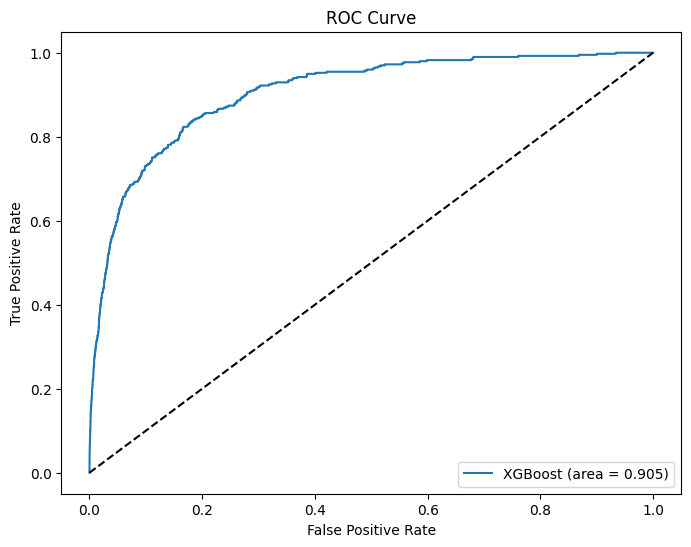

In [60]:
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

y_pred_proba = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='XGBoost (area = {:.3f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

        y_test  y_pred_proba
27245        1      0.989730
5785         1      0.970439
58350        1      0.917837
91629        0      0.846400
184688       0      0.827233
...        ...           ...
112442       0      0.006519
322110       0      0.006519
71741        0      0.006518
340059       0      0.006516
261016       0      0.006516

[10000 rows x 2 columns]
Number of 'yes' in the 10k: 303


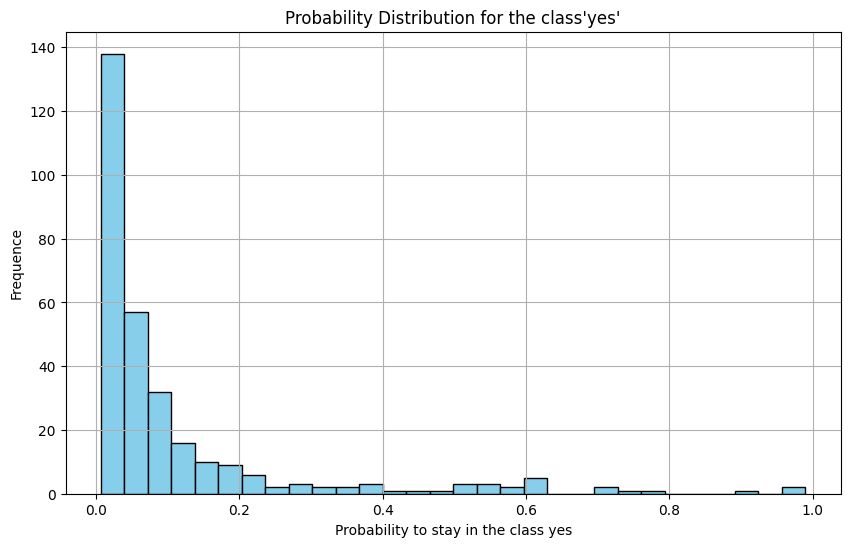

In [61]:
results_df = pd.DataFrame({
    'y_test': y_test,
    'y_pred_proba': y_pred_proba
})

results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si = results_df_si_sorted.head(10000)
print(top_10000_si)

count_si = top_10000_si[top_10000_si['y_test'] == 1].shape[0]

print("Number of 'yes' in the 10k:", count_si)
count_ones = np.sum(y_test == 1)

plt.figure(figsize=(10, 6))
plt.hist( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title("Probability Distribution for the class'yes'")
plt.xlabel('Probability to stay in the class yes')
plt.ylabel('Frequence')
plt.grid(True)
plt.show()


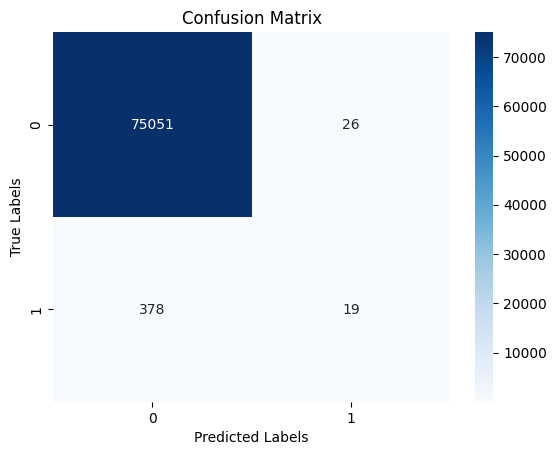

In [62]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

##### Same method but on the syntetic Dataset

In [63]:
synthetic_df =df.sample(n=70000, random_state=1)

        y_test  y_pred_proba
118461       0      0.658365
29746        1      0.586792
114029       0      0.471647
55280        0      0.432159
8718         1      0.408462
...        ...           ...
221583       0      0.000035
4103         0      0.000035
363119       0      0.000035
38105        0      0.000035
177876       0      0.000035

[10000 rows x 2 columns]
Number of 'yes' in the 10k: 79


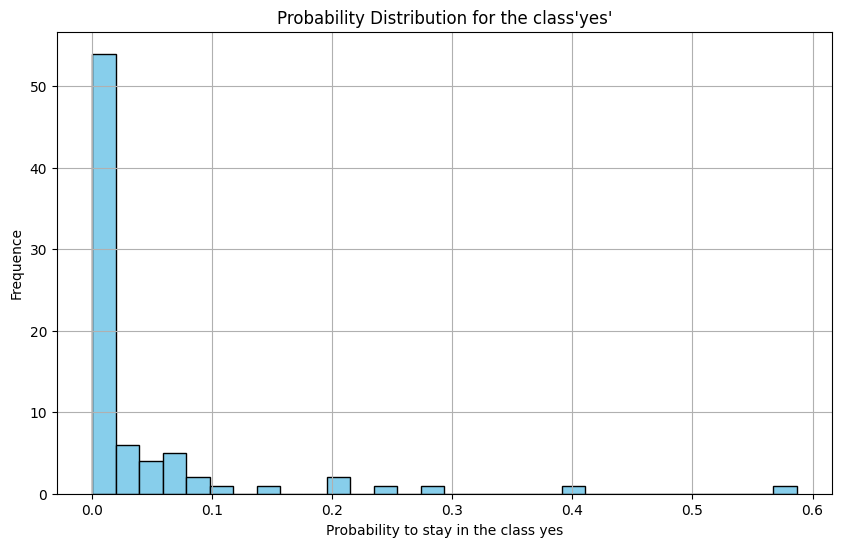

In [64]:
X_synthetic = synthetic_df.drop('Flag_Richiesta_Estinzione_cc', axis=1)
y_synthetic = synthetic_df['Flag_Richiesta_Estinzione_cc'].map({'no': 0, 'si': 1})  # Convert in 0 and 1
X_synthetic = pd.get_dummies(X_synthetic)
X_train, X_test, y_train, y_test = train_test_split(X_synthetic, y_synthetic, test_size=0.2, random_state=1)

X_train = clean_feature_names(X_train)
X_test = clean_feature_names(X_test)
X_train, X_test = X_train.align(X_test, join='inner', axis=1)

model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

y_pred_proba = model.predict_proba(X_test)[:, 1]

results_df = pd.DataFrame({
    'y_test': y_test,
    'y_pred_proba': y_pred_proba
})

results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si = results_df_si_sorted.head(10000)
print(top_10000_si)

count_si = top_10000_si[top_10000_si['y_test'] == 1].shape[0]

print("Number of 'yes' in the 10k:", count_si)
count_ones = np.sum(y_test == 1)

plt.figure(figsize=(10, 6))
plt.hist( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title("Probability Distribution for the class'yes'")
plt.xlabel('Probability to stay in the class yes')
plt.ylabel('Frequence')
plt.grid(True)
plt.show()


#### Second method: UnderSampling

In [65]:
from imblearn.under_sampling import RandomUnderSampler
X = df.drop('Flag_Richiesta_Estinzione_cc', axis=1)
y = df['Flag_Richiesta_Estinzione_cc'].map({'no': 0, 'si': 1})

# Splitting the data, stratifying to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Applying undersampling to balance the dataset
rus = RandomUnderSampler(sampling_strategy=0.03)  # Target ratio of 1 positive to 36 negatives
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

# Converting categorical variables to dummy/indicator variables
X_train_res = pd.get_dummies(X_train_res)
X_test = pd.get_dummies(X_test)

# Ensuring that both datasets have the same feature set
# Compute all possible columns that could appear after get_dummies
all_columns = set(X_train_res.columns) | set(X_test.columns)

# Adding any missing columns with default value of 0
for column in all_columns:
    if column not in X_train_res.columns:
        X_train_res[column] = 0
    if column not in X_test.columns:
        X_test[column] = 0

# Aligning columns in training and test datasets to ensure they are in the same order
X_train_res, X_test = X_train_res.align(X_test, join='inner', axis=1)

# Clean feature names if your function modifies feature naming convention
# This function should ensure valid Python identifiers for feature names if needed
X_train_res = clean_feature_names(X_train_res)
X_test = clean_feature_names(X_test)

print("Training features:", X_train_res.shape)
print("Testing features:", X_test.shape)

count_ones = (np.sum(y_test == 1))/(len(y_test))
print("Proportion of y_test = 1: ", count_ones)
print('Test set size',len(y_test))

Training features: (54452, 276)
Testing features: (75474, 276)
Proportion of y_test = 1:  0.0052600895672681985
Test set size 75474


In [66]:
print("Class distribution in the Unbalanced Dataset:")
print(df['Flag_Richiesta_Estinzione_cc'].value_counts())

print("Class distribution in the Balanced Dataset:")
print(y_train_res.value_counts())

Class distribution in the Unbalanced Dataset:
Flag_Richiesta_Estinzione_cc
no    375386
si      1983
Name: count, dtype: int64
Class distribution in the Balanced Dataset:
Flag_Richiesta_Estinzione_cc
0    52866
1     1586
Name: count, dtype: int64


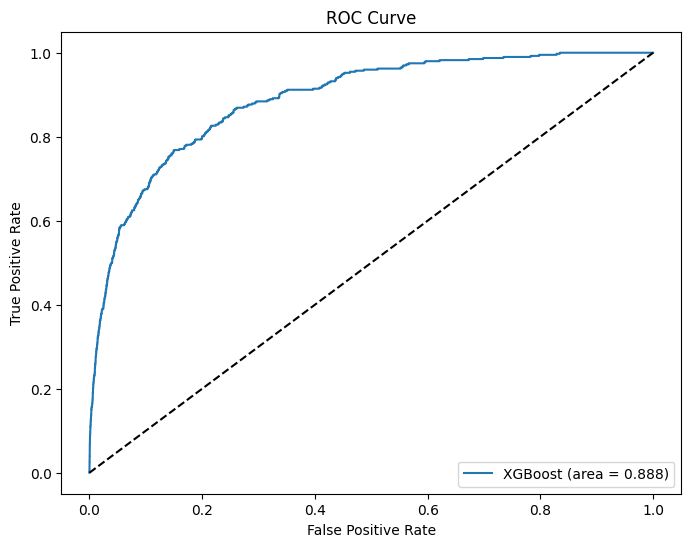

In [68]:
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train_res, y_train_res)

y_pred_proba = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='XGBoost (area = {:.3f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')  # Linea diagonale tratteggiata
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


        y_test  y_pred_proba
6844         1      0.995007
27147        1      0.993694
16142        1      0.989501
233423       0      0.988133
27245        1      0.986575
...        ...           ...
137193       0      0.034216
286086       0      0.034215
263901       0      0.034206
11197        0      0.034204
160537       0      0.034187

[10000 rows x 2 columns]
Number of 'yes' in the 10k: 291


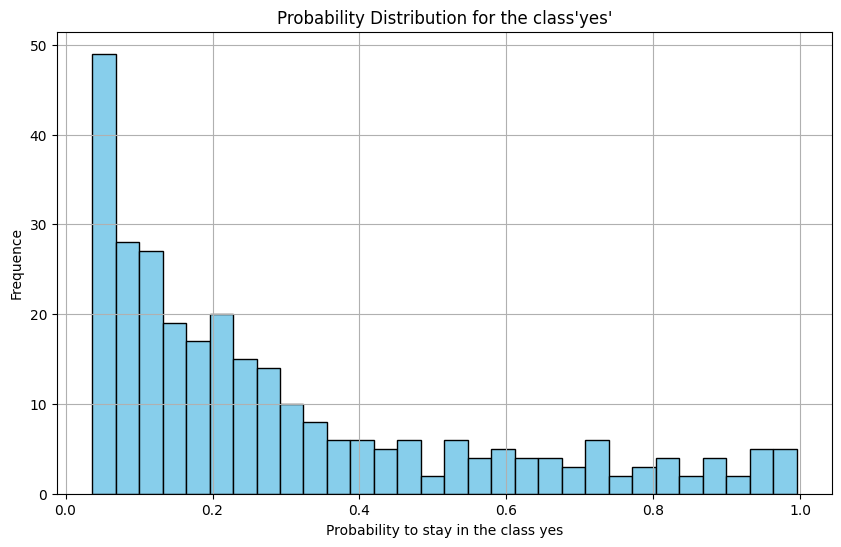

In [ ]:
results_df = pd.DataFrame({
    'y_test': y_test,
    'y_pred_proba': y_pred_proba
})

results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si = results_df_si_sorted.head(10000)
print(top_10000_si)

count_si = top_10000_si[top_10000_si['y_test'] == 1].shape[0]

print("Number of 'yes' in the 10k:", count_si)
count_ones = np.sum(y_test == 1)

plt.figure(figsize=(10, 6))
plt.hist( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title("Probability Distribution for the class'yes'")
plt.xlabel('Probability to stay in the class yes')
plt.ylabel('Frequence')
plt.grid(True)
plt.show()

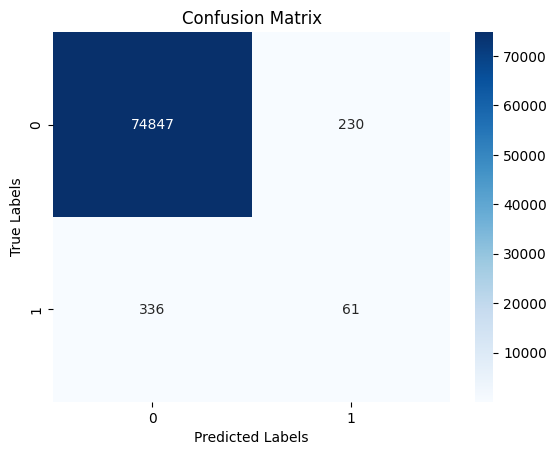

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

On the synthetic dataset

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
X = synthetic_df.drop('Flag_Richiesta_Estinzione_cc', axis=1)
y = synthetic_df['Flag_Richiesta_Estinzione_cc'].map({'no': 0, 'si': 1})

# Splitting the data, stratifying to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Applying undersampling to balance the dataset
rus = RandomUnderSampler(sampling_strategy=0.03)  # Target ratio of 1 positive to 36 negatives
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

# Converting categorical variables to dummy/indicator variables
X_train_res = pd.get_dummies(X_train_res)
X_test = pd.get_dummies(X_test)

# Ensuring that both datasets have the same feature set
# Compute all possible columns that could appear after get_dummies
all_columns = set(X_train_res.columns) | set(X_test.columns)

# Adding any missing columns with default value of 0
for column in all_columns:
    if column not in X_train_res.columns:
        X_train_res[column] = 0
    if column not in X_test.columns:
        X_test[column] = 0

# Aligning columns in training and test datasets to ensure they are in the same order
X_train_res, X_test = X_train_res.align(X_test, join='inner', axis=1)

# Clean feature names if your function modifies feature naming convention
# This function should ensure valid Python identifiers for feature names if needed
X_train_res = clean_feature_names(X_train_res)
X_test = clean_feature_names(X_test)

print("Training features:", X_train_res.shape)
print("Testing features:", X_test.shape)


Training features: (9819, 276)
Testing features: (14000, 276)


        y_test  y_pred_proba
236314       0      0.964395
263896       0      0.961657
136005       0      0.941862
49911        0      0.936613
27244        1      0.927151
...        ...           ...
227098       0      0.000139
111361       0      0.000139
368560       0      0.000139
351874       0      0.000139
370994       0      0.000139

[10000 rows x 2 columns]
Number of 'yes' in the 10k: 72


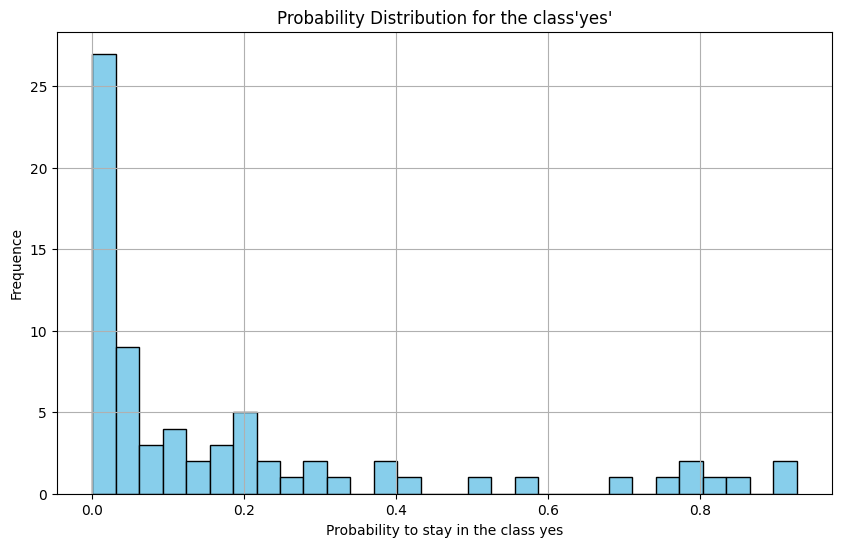

In [ ]:
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train_res, y_train_res)

y_pred_proba = model.predict_proba(X_test)[:, 1]

results_df = pd.DataFrame({
    'y_test': y_test,
    'y_pred_proba': y_pred_proba
})

results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si = results_df_si_sorted.head(10000)
print(top_10000_si)

count_si = top_10000_si[top_10000_si['y_test'] == 1].shape[0]

print("Number of 'yes' in the 10k:", count_si)
count_ones = np.sum(y_test == 1)

plt.figure(figsize=(10, 6))
plt.hist( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title("Probability Distribution for the class'yes'")
plt.xlabel('Probability to stay in the class yes')
plt.ylabel('Frequence')
plt.grid(True)
plt.show()

##### Third Method: OverSampling

In [75]:
from imblearn.over_sampling import RandomOverSampler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
ros = RandomOverSampler(sampling_strategy=0.2)  
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

# Converting categorical variables to dummy/indicator variables
X_train_res = pd.get_dummies(X_train_res)
X_test = pd.get_dummies(X_test)

# Ensuring that both datasets have the same feature set
# Compute all possible columns that could appear after get_dummies
all_columns = set(X_train_res.columns) | set(X_test.columns)

# Adding any missing columns with default value of 0
for column in all_columns:
    if column not in X_train_res.columns:
        X_train_res[column] = 0
    if column not in X_test.columns:
        X_test[column] = 0

# Aligning columns in training and test datasets to ensure they are in the same order
X_train_res, X_test = X_train_res.align(X_test, join='inner', axis=1)

# Clean feature names if your function modifies feature naming convention
# This function should ensure valid Python identifiers for feature names if needed
X_train_res = clean_feature_names(X_train_res)
X_test = clean_feature_names(X_test)

print("Training features:", X_train_res.shape)
print("Testing features:", X_test.shape)

count_ones = (np.sum(y_test == 1))/(len(y_test))
print("Proportion of y_test = 1: ", count_ones)
print('Test set size',len(y_test))

Training features: (360370, 276)
Testing features: (75474, 276)
Proportion of y_test = 1:  0.0052600895672681985
Test set size 75474


In [76]:
print("Class Distribution in the unbalanced Dataset:")
print(df['Flag_Richiesta_Estinzione_cc'].value_counts())

print("Class Distribution in the balanced dataset:")
print(y_train_res.value_counts())

Class Distribution in the unbalanced Dataset:
Flag_Richiesta_Estinzione_cc
no    375386
si      1983
Name: count, dtype: int64
Class Distribution in the balanced dataset:
Flag_Richiesta_Estinzione_cc
0    300309
1     60061
Name: count, dtype: int64


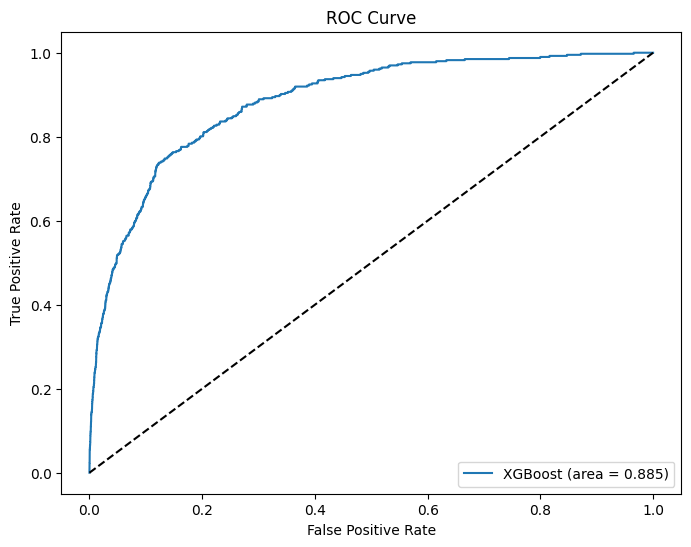

In [77]:
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train_res, y_train_res)

y_pred_proba = model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='XGBoost (area = {:.3f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')  # Linea diagonale tratteggiata
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=49) #cambiamo lo split per vedere se i nostri dati overfittano
X_train = pd.get_dummies(X_train) 
X_test = pd.get_dummies(X_test)

missing_columns_train = set(X_train_res.columns) - set(X_train.columns)
for col in missing_columns_train:
    X_train[col] = 0

missing_columns_test = set(X_train_res.columns) - set(X_test.columns)
for col in missing_columns_test:
    X_test[col] = 0

X_train = X_train[X_train_res.columns]
X_test = X_test[X_train_res.columns]

X_train = clean_feature_names(X_train)
X_test = clean_feature_names(X_test)
X_train, X_test = X_train.align(X_test, join='inner', axis=1)

# prediction usando il nostro classifier
y_pred_proba = model.predict_proba(X_test)[:, 1]

results_df = pd.DataFrame({
    'y_test': y_test,
    'y_pred_proba': y_pred_proba

})

#selezioniamo top 10k clienti con possibilità di essere SI
results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si = results_df_si_sorted.head(10000)
print(top_10000_si)


        y_test  y_pred_proba
6844         1      0.996827
16217        1      0.992537
38089        1      0.992369
54651        1      0.991775
62554        1      0.991697
...        ...           ...
269944       0      0.106949
60247        0      0.106928
210970       0      0.106889
364725       0      0.106839
53423        0      0.106831

[10000 rows x 2 columns]


Number of 'yes' in the 10k: 340
Number of 'yes' in the test set 360


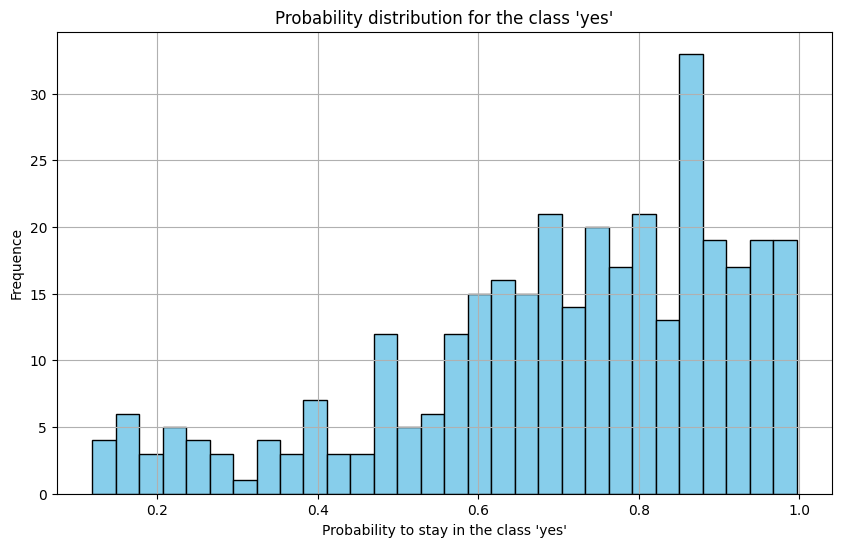

In [79]:
count_si = top_10000_si[top_10000_si['y_test'] == 1].shape[0]

print("Number of 'yes' in the 10k:", count_si)
count_ones = np.sum(y_test == 1)

print("Number of 'yes' in the test set", count_ones)

plt.figure(figsize=(10, 6))
plt.hist( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title("Probability distribution for the class 'yes'")
plt.xlabel("Probability to stay in the class 'yes'")
plt.ylabel('Frequence')
plt.grid(True)
plt.show()

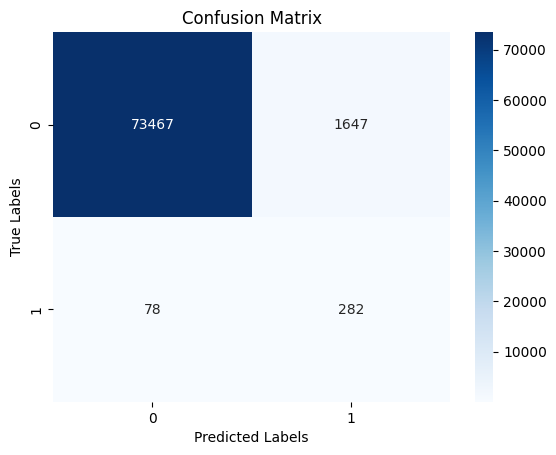

In [80]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

On the synthetic dataset

In [81]:
from imblearn.over_sampling import RandomOverSampler
X_synthetic = synthetic_df.drop('Flag_Richiesta_Estinzione_cc', axis=1)
y_synthetic = synthetic_df['Flag_Richiesta_Estinzione_cc'].map({'no': 0, 'si': 1})  # Convert in 0 and 1
X_synthetic = pd.get_dummies(X_synthetic)
X_train, X_test, y_train, y_test = train_test_split(X_synthetic, y_synthetic, test_size=0.2, random_state=1)
ros = RandomOverSampler(sampling_strategy=0.2)  
X_train_res, y_train_res = ros.fit_resample(X_train, y_train)

# Converting categorical variables to dummy/indicator variables
X_train_res = pd.get_dummies(X_train_res)
X_test = pd.get_dummies(X_test)

# Ensuring that both datasets have the same feature set
# Compute all possible columns that could appear after get_dummies
all_columns = set(X_train_res.columns) | set(X_test.columns)

# Adding any missing columns with default value of 0
for column in all_columns:
    if column not in X_train_res.columns:
        X_train_res[column] = 0
    if column not in X_test.columns:
        X_test[column] = 0

# Aligning columns in training and test datasets to ensure they are in the same order
X_train_res, X_test = X_train_res.align(X_test, join='inner', axis=1)

# Clean feature names if your function modifies feature naming convention
# This function should ensure valid Python identifiers for feature names if needed
X_train_res = clean_feature_names(X_train_res)
X_test = clean_feature_names(X_test)

print("Training features:", X_train_res.shape)
print("Testing features:", X_test.shape)

count_ones = (np.sum(y_test == 1))/(len(y_test))
print("Proportion of y_test = 1: ", count_ones)
print('Test set size',len(y_test))

Training features: (66867, 276)
Testing features: (14000, 276)
Proportion of y_test = 1:  0.0057857142857142855
Test set size 14000


        y_test  y_pred_proba
301133       0      0.940726
29746        1      0.938639
196616       0      0.911252
8718         1      0.909150
314086       0      0.903603
...        ...           ...
13496        0      0.000183
149960       0      0.000183
253771       0      0.000183
42923        0      0.000183
288972       0      0.000183

[10000 rows x 2 columns]
Number of 'yes' in the 10k: 80


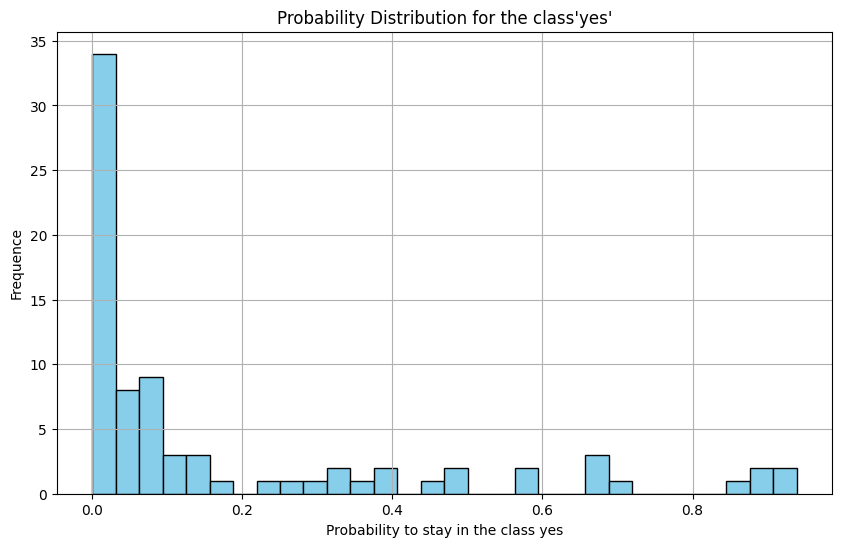

In [82]:
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train_res, y_train_res)

y_pred_proba = model.predict_proba(X_test)[:, 1]

results_df = pd.DataFrame({
    'y_test': y_test,
    'y_pred_proba': y_pred_proba
})

results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si = results_df_si_sorted.head(10000)
print(top_10000_si)

count_si = top_10000_si[top_10000_si['y_test'] == 1].shape[0]

print("Number of 'yes' in the 10k:", count_si)
count_ones = np.sum(y_test == 1)

plt.figure(figsize=(10, 6))
plt.hist( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title("Probability Distribution for the class'yes'")
plt.xlabel('Probability to stay in the class yes')
plt.ylabel('Frequence')
plt.grid(True)
plt.show()

##### Fourth method: Cost-Sensitive Learning with simple sampling

In [98]:
X = df.drop('Flag_Richiesta_Estinzione_cc', axis=1)
y = df['Flag_Richiesta_Estinzione_cc'].map({'no': 0, 'si': 1}) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

XX = pd.get_dummies(X)
missing_columns_train = set(XX.columns) - set(X_train.columns)
for col in missing_columns_train:
    X_train[col] = 0

missing_columns_test = set(XX.columns) - set(X_test.columns)
for col in missing_columns_test:
    X_test[col] = 0

X_train = X_train[XX.columns]
X_test = X_test[XX.columns]


X_train_res = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

X_train_res = clean_feature_names(X_train_res)
X_test = clean_feature_names(X_test)
X_train_res, X_test = X_train_res.align(X_test, join='inner', axis=1)

count_ones = (np.sum(y_test == 1))/(len(y_test))
print("Proportion of y_test = 1: ", count_ones)
print('Test set size',len(y_test))

C:\Users\maria\AppData\Local\Temp\ipykernel_16972\2109788550.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train[col] = 0
C:\Users\maria\AppData\Local\Temp\ipykernel_16972\2109788550.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train[col] = 0
C:\Users\maria\AppData\Local\Temp\ipykernel_16972\2109788550.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1)

Proportion of y_test = 1:  0.0052600895672681985
Test set size 75474


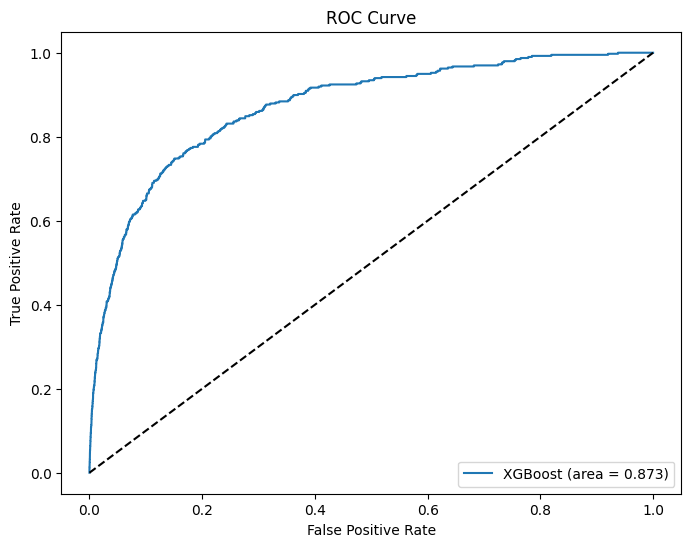

In [99]:
scale_pos_weight = len(y[y == 0]) / len(y[y == 1]) # sbilanciamento tra le classi

model = xgb.XGBClassifier(
    objective='binary:logistic', 
    scale_pos_weight=scale_pos_weight, 
    use_label_encoder=False, 
    eval_metric='logloss'
)

model.fit(X_train_res, y_train)

y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calcolo della curva ROC e dell'AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

# Visualizzazione della curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='XGBoost (area = {:.3f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')  # Linea diagonale tratteggiata
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


Number of 'yes' in the 10k: 363
Number of 'yes' in the test set 397


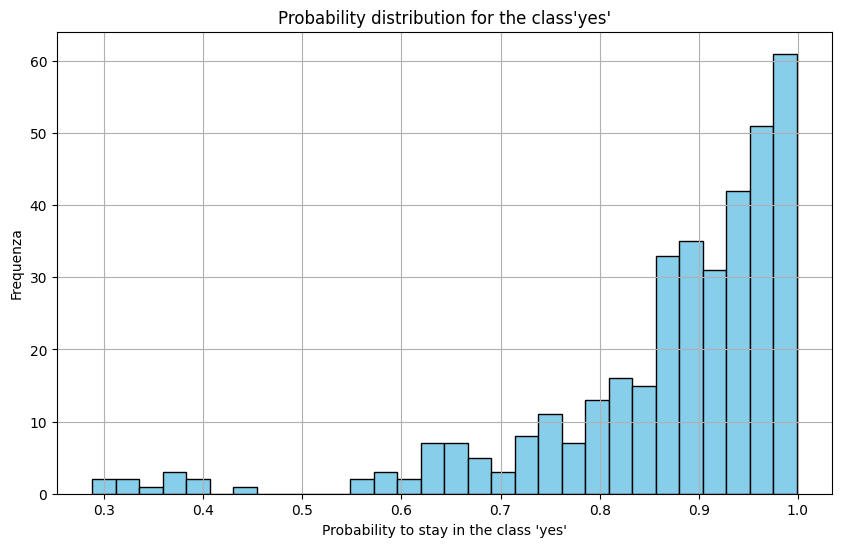

In [100]:
print("Number of 'yes' in the 10k:", count_si)
count_ones = np.sum(y_test == 1)

print("Number of 'yes' in the test set", count_ones)

plt.figure(figsize=(10, 6))
plt.hist( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title("Probability distribution for the class'yes'")
plt.xlabel("Probability to stay in the class 'yes'")
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

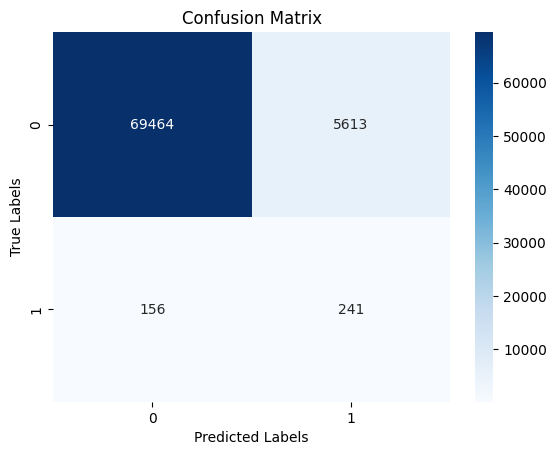

In [101]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

##### Same method but on the syntetic Dataset

In [102]:
X = synthetic_df.drop('Flag_Richiesta_Estinzione_cc', axis=1)
y = synthetic_df['Flag_Richiesta_Estinzione_cc'].map({'no': 0, 'si': 1}) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

XX = pd.get_dummies(X)
missing_columns_train = set(XX.columns) - set(X_train.columns)
for col in missing_columns_train:
    X_train[col] = 0

missing_columns_test = set(XX.columns) - set(X_test.columns)
for col in missing_columns_test:
    X_test[col] = 0

X_train = X_train[XX.columns]
X_test = X_test[XX.columns]


X_train_res = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

X_train_res = clean_feature_names(X_train_res)
X_test = clean_feature_names(X_test)
X_train_res, X_test = X_train_res.align(X_test, join='inner', axis=1)

count_ones = (np.sum(y_test == 1))/(len(y_test))
print("Proportion of y_test = 1: ", count_ones)
print('Test set size',len(y_test))

scale_pos_weight = len(y[y == 0]) / len(y[y == 1]) # sbilanciamento tra le classi

model = xgb.XGBClassifier(
    objective='binary:logistic', 
    scale_pos_weight=scale_pos_weight, 
    use_label_encoder=False, 
    eval_metric='logloss'
)

model.fit(X_train_res, y_train)

y_pred_proba = model.predict_proba(X_test)[:, 1]


C:\Users\maria\AppData\Local\Temp\ipykernel_16972\3451072712.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train[col] = 0
C:\Users\maria\AppData\Local\Temp\ipykernel_16972\3451072712.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_train[col] = 0
C:\Users\maria\AppData\Local\Temp\ipykernel_16972\3451072712.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1)

Proportion of y_test = 1:  0.005142857142857143
Test set size 14000


Number of 'yes' in the 10k: 363
Number of 'yes' in the test set 72


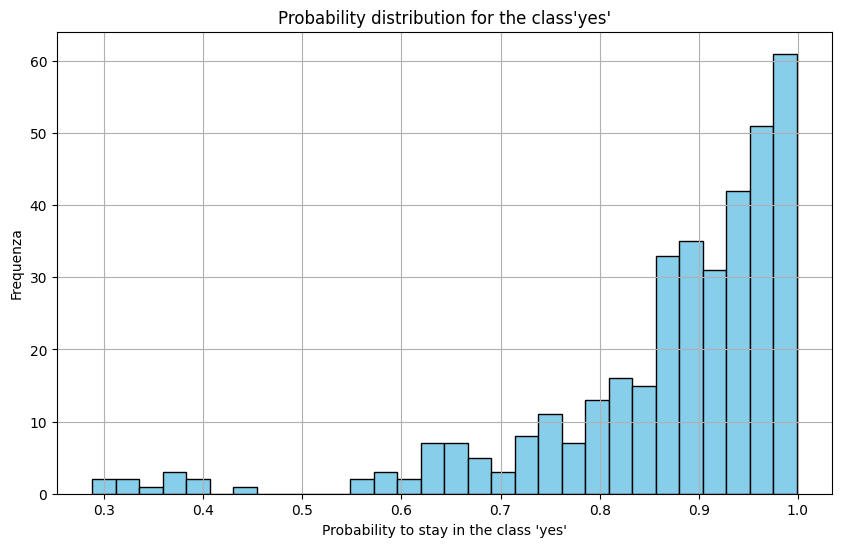

In [103]:
print("Number of 'yes' in the 10k:", count_si)
count_ones = np.sum(y_test == 1)

print("Number of 'yes' in the test set", count_ones)

plt.figure(figsize=(10, 6))
plt.hist( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title("Probability distribution for the class'yes'")
plt.xlabel("Probability to stay in the class 'yes'")
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

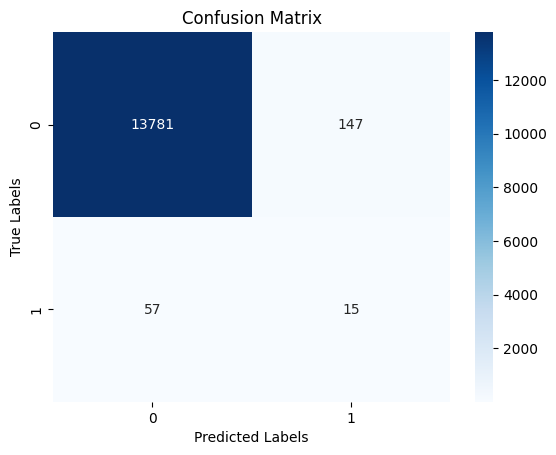

In [104]:
y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

##### The best sampling method is Cost-Sensitive Learning. Cost-sensitive learning and sampling techniques are two separate approaches in machine learning, but they can be used together to address different aspects of the learning problem, particularly in scenarios with imbalanced datasets. 
##### Cost-sensitive learning focuses on adjusting the learning algorithm to minimize a cost function that incorporates the costs associated with different types of errors. This approach ensures that the model is optimized to make decisions that minimize the overall cost, taking into account the relative importance of different types of errors. Instead of applying sampling techniques uniformly to the entire dataset, you can prioritize sampling instances based on their associated costs. 
##### After random sampling, cost-sensitive learning comes into play. The learning algorithm is trained to minimize a cost function that takes into account the costs associated with different types of errors. This means that during training, the model is optimized to make predictions that minimize the overall cost, rather than just the classification error.
##### The combination of random sampling and cost-sensitive learning can lead to a more robust model regarding class imbalance and considering the costs associated with classification errors. However, it's important to note that random sampling may not select instances based on their associated costs, so it might be ineffective in fully capturing the complexity of costs in the dataset.